In [8]:
import os
#os.chdir("/insar-data/Tocantins/mintpy")

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mintpy.utils import readfile
import h5py
import csv
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

DATA_PATH = '/insar-data'
PROJECT_NAME = "Tocantins"
ASSET_NAME = "Ponte Juscelino Kubitschek"
ANALYSIS_PERIOD = "20190101-20241218"
#os.chdir('/insar-data/Miaplpy_Tocantins/miaplpy/')
os.chdir(f"{DATA_PATH}/{PROJECT_NAME}/mintpy")

# --- helpers ---
def parse_points(s):
    pts = []
    for item in s.split(";"):
        lon_str, lat_str = item.strip().split(",")
        pts.append((float(lat_str), float(lon_str)))
    return pts

def latlon_to_rc(meta, lat, lon):
    x0 = float(meta["X_FIRST"])
    y0 = float(meta["Y_FIRST"])
    dx = float(meta["X_STEP"])
    dy = float(meta["Y_STEP"])    # often negative
    width  = int(meta["WIDTH"])
    length = int(meta["LENGTH"])
    col = int(round((lon - x0) / dx))
    row = int(round((lat - y0) / dy))
    if not (0 <= row < length and 0 <= col < width):
        raise IndexError(f"Point ({lat:.6f},{lon:.6f}) -> (row={row}, col={col}) outside data [{length}x{width}]")
    return row, col

def _to_str_array(x):
    """Normalize various 'date list' representations to an array of 'YYYYMMDD' strings."""
    if isinstance(x, np.ndarray):
        if x.dtype.kind in ("S", "U", "O"):
            arr = [xi.decode() if isinstance(xi, (bytes, bytearray)) else str(xi) for xi in x.tolist()]
        else:  # e.g., int array like [20171005, ...]
            arr = [f"{int(xi):08d}" for xi in x.tolist()]
    elif isinstance(x, (bytes, bytearray, str)):
        s = x.decode() if isinstance(x, (bytes, bytearray)) else x
        arr = [t for t in s.replace(",", " ").split() if t]
    else:
        arr = [str(x)]
    return np.array(arr)

def get_dates(h5_file):
    """Robust date reader: try '/date' dataset; fall back to DATE_LIST or similar attrs (root or '/timeseries')."""
    try:
        dates_raw, _ = readfile.read(h5_file, datasetName="date")
        return np.array([d.decode() if isinstance(d, (bytes, bytearray)) else str(d) for d in dates_raw])
    except Exception:
        pass

    with h5py.File(h5_file, "r") as f:
        if "date" in f:
            return _to_str_array(f["date"][:])
        root_keys = ["DATE_LIST", "DATE", "DATES"]
        ts_keys   = ["DATE_LIST", "DATE", "DATES", "date"]
        for k in root_keys:
            if k in f.attrs:
                return _to_str_array(f.attrs[k])
        if "timeseries" in f:
            for k in ts_keys:
                if k in f["timeseries"].attrs:
                    return _to_str_array(f["timeseries"].attrs[k])
        try:
            _, meta = readfile.read(h5_file)
            for k in ["DATE_LIST", "DATE", "DATES"]:
                if k in meta:
                    return _to_str_array(meta[k])
        except Exception:
            pass

    raise RuntimeError("Could not find dates in the file (no '/date' dataset or date attributes like 'DATE_LIST').")

# ---------- inputs ----------
sections = {
    "East_S1": {
        "points_str": "-47.46159935406088,-6.56050416644849;-47.46146373429202,-6.560468920830724;-47.46133077128363,-6.560438563882936;-47.46134626674425,-6.560370289325007;-47.46147585536021,-6.560402328449132;-47.46161531958357,-6.560432945876576;-47.46159935406088,-6.56050416644849 ",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "East_S2": {
        "points_str": "-47.46130348920288,-6.560428485442362;-47.46116313409231,-6.560395837229959;-47.46099575417598,-6.56035720925049 ;-47.46101049572228,-6.560297594929002;-47.46117177651878,-6.560333628088344;-47.46131497525779,-6.560366494372492;-47.46130348920288,-6.560428485442362",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "East_S3": {
        "points_str": "-47.46095796677579,-6.560348832338948;-47.46079646069482,-6.560309069960558;-47.46063750571581,-6.560273739331335;-47.46065103675672,-6.560214045251122;-47.46080687806177,-6.560249257433264;-47.46096836239918,-6.560286122425554;-47.46095796677579,-6.560348832338948",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "Mid_S1": {
        "points_str": "-47.46060900757468,-6.560198250054605;-47.46059449768229,-6.560259839899425;-47.46043302983708,-6.560225335878401;-47.4602880936233,-6.560191829861957;-47.46029825726428,-6.560126693728696;-47.46045778823055,-6.560162137090549;-47.46060900757468,-6.560198250054605",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "Mid_S2": {
        "points_str": "-47.46024701362929,-6.560183296170492;-47.46008648854441,-6.560148039799448;-47.45987171852053,-6.560095321136375;-47.45987808228551,-6.560033875740226;-47.4600987944757,-6.560085359451784;-47.46026005484211,-6.560121155016233;-47.46024701362929,-6.560183296170492",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "Mid_S3": {
        "points_str": "-47.45984185771984,-6.560087645971586;-47.4596453876067,-6.560044880155928;-47.45944605995008,-6.559999092449311;-47.45946274437678,-6.559938014459747;-47.45965617287498,-6.55998361919587;-47.45985112158873,-6.560027804382649;-47.45984185771984,-6.560087645971586",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "West_S1": {
        "points_str": "-47.45940799922867,-6.559919641117872;-47.45939199985407,-6.559981281395009;-47.45919391730619,-6.559942865288215;-47.45899807741331,-6.55989957229934;-47.45901043519845,-6.559835377698351;-47.45921368939044,-6.559877483777482;-47.45940799922867,-6.559919641117872",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "West_S2": {
        "points_str": "-47.45896661527618,-6.559894742286868;-47.45881581930044,-6.559862098020168;-47.45861712759962,-6.559816215657076;-47.45863066775841,-6.559756601631374;-47.45882659329846,-6.559799414525194;-47.45898044201245,-6.559830642898655;-47.45896661527618,-6.559894742286868",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    "West_S3": {
        "points_str": "-47.45858651753384,-6.559806466086134;-47.45844677452839,-6.559778545068137;-47.45830264709105,-6.559746196402275;-47.45831742489085,-6.559683801501984;-47.45846016447318,-6.55971607723477;-47.45860150386818,-6.559748360350736;-47.45858651753384,-6.559806466086134",
        "labels": "P1;P2;P3;P4;P5;P6"
    },
    
}

h5_file = f'{DATA_PATH}/{PROJECT_NAME}/mintpy/geo/geo_timeseries_ERA5_demErr.h5'


# ---------- section-level anomaly config ----------
SEC_ROLL_MED_WIN = 5   # window (in acquisitions) for rolling median baseline (odd numbers: 5, 7, 9...)
SEC_CM_THRESH    = 0.2 # cm threshold on residual from baseline
SEC_Z_THRESH     = 2.0 # robust z-score threshold on residual
SEC_MIN_CONSEC   = 2   # require at least this many consecutive anomalous dates

# ---------- small utilities ----------
def _max_run_length(bool_arr):
    """Max consecutive True run length in a 1D boolean array."""
    m = 0
    cur = 0
    for b in bool_arr:
        cur = cur + 1 if b else 0
        if cur > m:
            m = cur
    return m

def _enforce_min_consecutive(mask, k):
    """Keep only runs of True with length >= k."""
    if k <= 1:
        return mask.copy()
    out = np.zeros_like(mask, dtype=bool)
    n = mask.size
    i = 0
    while i < n:
        if mask[i]:
            j = i
            while j < n and mask[j]:
                j += 1
            if (j - i) >= k:
                out[i:j] = True
            i = j
        else:
            i += 1
    return out

def generate_pdf_report(pdf_filename, project_name, asset_name, analysis_period, 
                       fig_files, anomaly_data, section_summary_rows):
    """Generate a comprehensive PDF report with title page, plots, and anomaly table."""
    
    with PdfPages(pdf_filename) as pdf:
        # Title Page
        fig_title = plt.figure(figsize=(8.5, 11))
        plt.axis('off')
        
        # Main title
        plt.text(0.5, 0.8, f'InSAR Analysis Report', 
                ha='center', va='center', fontsize=24, fontweight='bold')
        
        # Project and asset info
        plt.text(0.5, 0.7, f'Project: {project_name}', 
                ha='center', va='center', fontsize=18)
        plt.text(0.5, 0.65, f'Asset: {asset_name}', 
                ha='center', va='center', fontsize=18)
        
        # Analysis period
        plt.text(0.5, 0.55, f'Analysis Period', 
                ha='center', va='center', fontsize=16, fontweight='bold')
        plt.text(0.5, 0.5, f'{analysis_period}', 
                ha='center', va='center', fontsize=14)
        
        # Report generation date
        plt.text(0.5, 0.3, f'Report Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}', 
                ha='center', va='center', fontsize=12)
        
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        pdf.savefig(fig_title, bbox_inches='tight')
        plt.close(fig_title)
        
        # Add the three plots
        for fig_file in fig_files:
            if os.path.exists(fig_file):
                # Read and display the saved figure
                fig = plt.figure(figsize=(11, 8.5))
                img = plt.imread(fig_file)
                plt.imshow(img)
                plt.axis('off')
                plt.tight_layout()
                pdf.savefig(fig, bbox_inches='tight')
                plt.close(fig)
        
        # Anomaly Summary Table
        if section_summary_rows:
            fig_table = plt.figure(figsize=(11, 8.5))
            plt.axis('off')
            
            # Table title
            plt.text(0.5, 0.95, 'Flagged Anomalies Summary', 
                    ha='center', va='top', fontsize=16, fontweight='bold')
            
            # Prepare table data
            headers = ['Section', 'Flagged Dates', 'Max Consecutive', 
                      'First Anomaly', 'Last Anomaly', 'Max |Residual| (cm)', 'Max |Z-score|']
            
            table_data = []
            for row in section_summary_rows:
                sec_name, n_flag, max_run, first_date, last_date, max_abs_resid, max_abs_z = row[:7]
                table_data.append([
                    sec_name, 
                    str(n_flag), 
                    str(max_run),
                    first_date if first_date else 'N/A',
                    last_date if last_date else 'N/A',
                    f'{max_abs_resid:.2f}',
                    f'{max_abs_z:.2f}'
                ])
            
            # Create table
            table = plt.table(cellText=table_data,
                             colLabels=headers,
                             cellLoc='center',
                             loc='center',
                             bbox=[0.05, 0.1, 0.9, 0.8])
            
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1, 2)
            
            # Style the table
            for i in range(len(headers)):
                table[(0, i)].set_facecolor('#40466e')
                table[(0, i)].set_text_props(weight='bold', color='white')
            
            # Color rows with anomalies
            for i, row in enumerate(table_data):
                if int(row[1]) > 0:  # If there are flagged dates
                    for j in range(len(headers)):
                        table[(i+1, j)].set_facecolor('#ffcccc')
            
            pdf.savefig(fig_table, bbox_inches='tight')
            plt.close(fig_table)
    
    print(f"PDF report generated: {pdf_filename}")

def _rolling_median(x, win):
    """Rolling median with edge handling (centered window; uses nanmedian)."""
    x = np.asarray(x, dtype=float)
    n = x.size
    half = win // 2
    rm = np.full(n, np.nan)
    for i in range(n):
        i0 = max(0, i - half)
        i1 = min(n, i + half + 1)
        rm[i] = np.nanmedian(x[i0:i1])
    return rm

# ---------- read data ----------
ts, meta = readfile.read(h5_file)  # 3-D (n_date, length, width), meters
print("timeseries shape:", ts.shape)

dates = get_dates(h5_file)
dates_dt = np.array([datetime.strptime(d, "%Y%m%d") for d in dates])

# ---------- compute per-section averages + section-level anomalies ----------
section_avg = {}             # name -> (n_dates,) cm
section_anom_mask = {}       # name -> (n_dates,) bool
section_resid = {}           # name -> residual cm (avg - rolling median)
section_flagged_idx = {}     # name -> indices of anomalous dates
section_z = {}               # name -> robust z-score array (n_dates,)
section_summary_rows = []    # rows for per-section summary

for sec_name, cfg in sections.items():
    pts = parse_points(cfg["points_str"])

    # collect each point's time-series (cm)
    series_cm = []
    for (lat, lon) in pts:
        r, c = latlon_to_rc(meta, lat, lon)
        disp_m = ts[:, r, c]
        series_cm.append(disp_m * 100.0)  # m -> cm

    arr = np.vstack(series_cm)                # (n_pts, n_dates)
    avg_cm = np.nanmean(arr, axis=0)         # (n_dates,)
    section_avg[sec_name] = avg_cm

    # residual vs. rolling-median baseline
    base = _rolling_median(avg_cm, SEC_ROLL_MED_WIN)
    resid = avg_cm - base
    section_resid[sec_name] = resid

    # robust z-score of residual
    med_r = np.nanmedian(resid)
    mad_r = np.nanmedian(np.abs(resid - med_r))
    robust_std = 1.4826 * mad_r + 1e-9
    z = (resid - med_r) / robust_std
    section_z[sec_name] = z

    # anomaly mask and persistence constraint
    raw_mask = (np.abs(resid) > SEC_CM_THRESH) & (np.abs(z) > SEC_Z_THRESH)
    mask = _enforce_min_consecutive(raw_mask, SEC_MIN_CONSEC)
    section_anom_mask[sec_name] = mask
    section_flagged_idx[sec_name] = np.where(mask)[0]

    # summary
    n_flag = int(np.nansum(mask))
    max_run = _max_run_length(mask)
    first_date = dates[np.where(mask)[0][0]] if n_flag > 0 else ""
    last_date  = dates[np.where(mask)[0][-1]] if n_flag > 0 else ""
    max_abs_resid = float(np.nanmax(np.abs(resid))) if np.isfinite(resid).any() else 0.0
    max_abs_z     = float(np.nanmax(np.abs(z))) if np.isfinite(z).any() else 0.0

    section_summary_rows.append([
        sec_name, n_flag, max_run, first_date, last_date, max_abs_resid, max_abs_z,
        SEC_ROLL_MED_WIN, SEC_CM_THRESH, SEC_Z_THRESH, SEC_MIN_CONSEC
    ])

# ---------- smoothing filter configuration ----------
SMOOTH_FILTER_WIN = 21  # window size for smoothing filter (odd number)

def apply_smoothing_filter(series, window=5, method='gaussian'):
    """
    Apply smoothing filter to make time series smoother.
    
    Parameters:
    - series: input time series (1D array)
    - window: window size for smoothing
    - method: smoothing method ('moving_avg', 'gaussian', 'savgol')
    
    Returns:
    - smoothed_series: smoothed time series
    """
    from scipy import ndimage
    from scipy.signal import savgol_filter
    
    series = np.array(series, dtype=float)
    
    if method == 'moving_avg':
        # Simple moving average
        return _rolling_median(series, window)  # Reuse existing rolling function but with mean
    
    elif method == 'gaussian':
        # Gaussian smoothing - good for preserving overall trends while reducing noise
        sigma = window / 3.0  # Standard deviation for Gaussian kernel
        # Handle NaN values
        mask = ~np.isnan(series)
        if np.any(mask):
            smoothed = series.copy()
            smoothed[mask] = ndimage.gaussian_filter1d(series[mask], sigma=sigma)
            return smoothed
        else:
            return series
    
    elif method == 'savgol':
        # Savitzky-Golay filter - good for preserving peaks while smoothing
        if len(series) > window and window >= 3:
            # Handle NaN values by interpolating first
            mask = ~np.isnan(series)
            if np.sum(mask) > window:
                from scipy.interpolate import interp1d
                valid_indices = np.where(mask)[0]
                if len(valid_indices) > 2:
                    f = interp1d(valid_indices, series[valid_indices], 
                               kind='linear', fill_value='extrapolate')
                    series_interp = f(np.arange(len(series)))
                    return savgol_filter(series_interp, window, polyorder=2)
        return series
    
    return series



timeseries shape: (89, 422, 315)


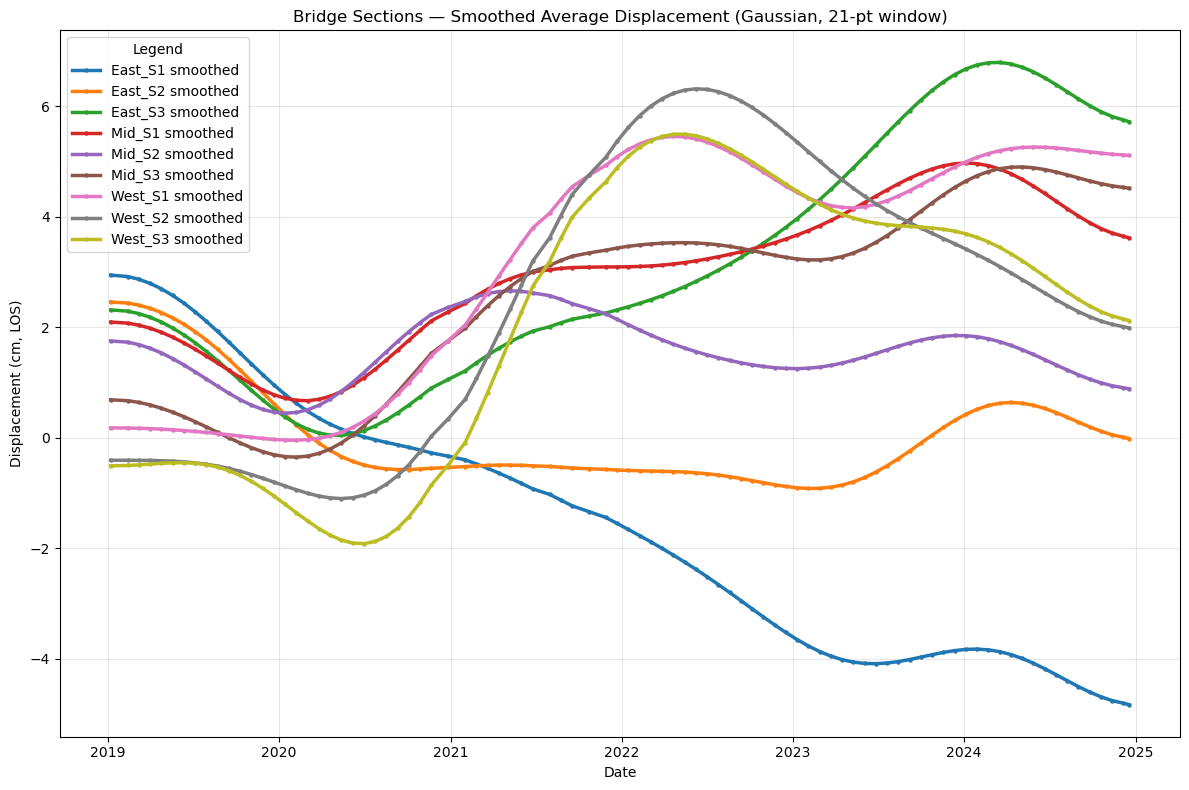

In [7]:
# 4) smoothed averages plot
section_smoothed = {}  # name -> (n_dates,) cm, smoothed

fig4 = plt.figure(figsize=(12, 8))
for sec_name, avg_series_cm in section_avg.items():
    # Apply smoothing filter
    smoothed_series = apply_smoothing_filter(
        avg_series_cm, 
        window=SMOOTH_FILTER_WIN, 
        method='gaussian'
    )
    section_smoothed[sec_name] = smoothed_series
    
    # Plot original series (lighter, thinner)
    #plt.plot(dates_dt, avg_series_cm, linewidth=1.2, alpha=0.5, linestyle='--',
    #         label=f"{sec_name} original")
    
    # Plot smoothed series (main line, thicker and smoother)
    #plt.plot(dates_dt, smoothed_series, linewidth=2.5, marker="o", markersize=4, 
    #         label=f"{sec_name} smoothed")
    plt.plot(dates_dt, smoothed_series, linewidth=2.5, marker="o", markersize=2.2, 
             label=f"{sec_name} smoothed")


    
plt.xlabel("Date")
plt.ylabel("Displacement (cm, LOS)")
plt.title(f"Bridge Sections — Smoothed Average Displacement (Gaussian, {SMOOTH_FILTER_WIN}-pt window)")
plt.grid(True, alpha=0.3)
plt.legend(title="Legend")
plt.tight_layout()

# Save the smoothed figure
#smoothed_fig_name = f"{outbase}_ts_sectionAvgs_smoothed.png"
#plt.savefig(smoothed_fig_name, dpi=300, bbox_inches='tight')
plt.show()

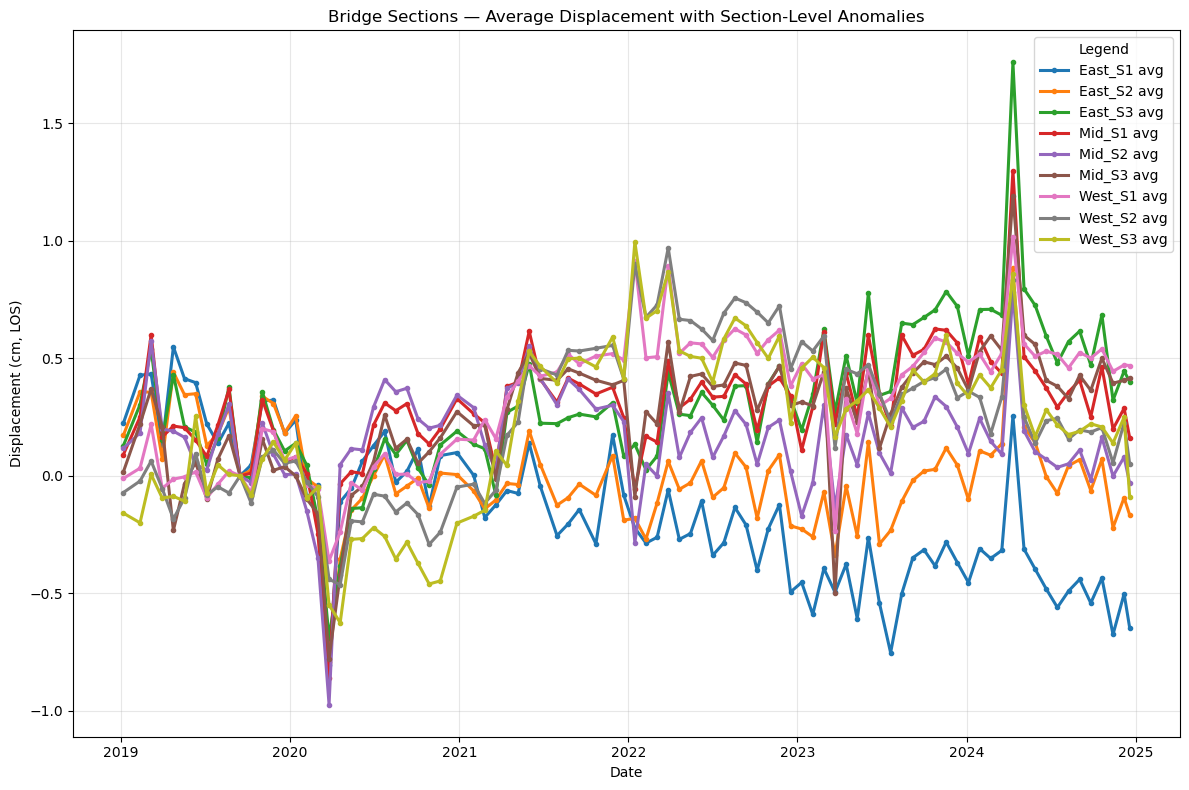

In [9]:
# 1) section averages with anomaly markers
fig1 = plt.figure(figsize=(12, 8))
for sec_name, avg_series_cm in section_avg.items():
    plt.plot(dates_dt, avg_series_cm, linewidth=2.2, marker="o", markersize=3, label=f"{sec_name} avg")
    idx = section_flagged_idx[sec_name]
plt.xlabel("Date")
plt.ylabel("Displacement (cm, LOS)")
plt.title("Bridge Sections — Average Displacement with Section-Level Anomalies")
plt.grid(True, alpha=0.3)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()


In [18]:
!plot_transection.py /insar-data/Tocantins/mintpy/geo/geo_velocity.h5 \
  --start-lalo -6.560723961470407 -47.46259449545149 \
  --end-lalo   -6.559509819917357 -47.45733463678253 \
  --save \
  -o /insar-data/Tocantins/mintpy/bridge_vel_transect.txt


plot_transection.py /insar-data/Tocantins/mintpy/geo/geo_velocity.h5 --start-lalo -6.560723961470407 -47.46259449545149 --end-lalo -6.559509819917357 -47.45733463678253 --save -o /insar-data/Tocantins/mintpy/bridge_vel_transect.txt
run view.py in MintPy version 1.6.2, date 2025-07-07
input file is velocity file: /insar-data/Tocantins/mintpy/geo/geo_velocity.h5 in float32 format
file size in y/x: (422, 315)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file geo_velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 315, 422)
subset coverage in y/x: (0, 0, 315, 422)
data   coverage in lat/lon: (-47.502326925470726, -6.51959410669126, -47.39660862989144, -6.6098154591703455)
subset coverage in lat/lon: (-47.502326925470726, -6.51959410669126, -47.39660862989144, -6.6098154591703455)
------------------------------------------------------------------------
colormap: jet
figure title: geo_ve

In [25]:
!plot_transection.py /insar-data/Tocantins/mintpy/geo/geo_velocity.h5 \
  --dset velocity \
  --start-lalo -6.560723961470407 -47.46259449545149 \
  --end-lalo   -6.559509819917357 -47.45733463678253 \
  --interpolation bilinear \
  --dpi 300 --save --nodisplay \
  --figext .pdf 

plot_transection.py /insar-data/Tocantins/mintpy/geo/geo_velocity.h5 --dset velocity --start-lalo -6.560723961470407 -47.46259449545149 --end-lalo -6.559509819917357 -47.45733463678253 --interpolation bilinear --dpi 300 --save --nodisplay --figext .pdf
run view.py in MintPy version 1.6.2, date 2025-07-07
input file is velocity file: /insar-data/Tocantins/mintpy/geo/geo_velocity.h5 in float32 format
file size in y/x: (422, 315)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file geo_velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 315, 422)
subset coverage in y/x: (0, 0, 315, 422)
data   coverage in lat/lon: (-47.502326925470726, -6.51959410669126, -47.39660862989144, -6.6098154591703455)
subset coverage in lat/lon: (-47.502326925470726, -6.51959410669126, -47.39660862989144, -6.6098154591703455)
------------------------------------------------------------------------
colormap: jet

In [23]:
!plot_transection.py -h

usage: plot_transection.py [-h] [--dset DSET] [-v VMIN VMAX]
                           [--offset OFFSET [OFFSET ...]] [--noverbose]
                           [--start-yx Y0 X0] [--end-yx Y1 X1]
                           [--start-lalo LAT0 LON0] [--end-lalo LAT1 LON1]
                           [--line-file LOLA_FILE]
                           [--interpolation {nearest,bilinear,cubic}]
                           [--ms MARKER_SIZE] [--fontsize FONT_SIZE]
                           [--fontcolor FONT_COLOR] [--nowhitespace]
                           [--noaxis] [--notick] [--ylabel-rot YLABEL_ROT]
                           [-c COLORMAP] [--cm-lut NUM]
                           [--cm-vlist CMAP_VLIST CMAP_VLIST CMAP_VLIST]
                           [--nocbar]
                           [--cbar-nbins NUM | --cbar-ticks NUM [NUM ...]]
                           [--cbar-ext {None,both,min,max,neither}]
                           [--cbar-label CBAR_LABEL] [--cbar-loc CBAR_LOC]
          